# Randomized Optimization
1. Randomized hill climbing
2. Simulated annealing
3. Genetic algorithm
4. MIMIC

## Import packages

In [1]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
import matplotlib.pyplot as plt
import numpy as np
import time

## Define Three problems
1. Sharp Global Peak
2. Wide Basin Global Peak
3. 0-1 Knapsack Problem

In [2]:
def plot_fitness_function(fitness_func):
    x = list(range(1000))
    y = [fitness_func(i) for i in x]
    plt.plot(x, y)
    plt.title('Fitness function')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

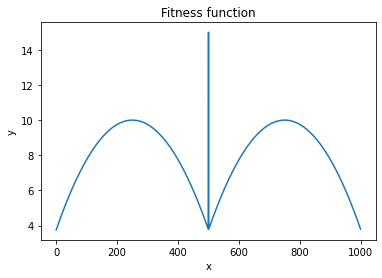

In [3]:
# Problem 1: Sharp Global Peak
def f1(x):
    """
    Fitness must be non-negative, as mlrose evaluates probability simply as fitness/sum(fitness in population)
    """
    if isinstance(x, np.ndarray):  # For compatibility with (one-element) state vector in mlrose
        assert x.shape == (1,)
        x = x[0]
    assert 0 <= x < 1000
    if 0 <= x < 500:
        return 10 - (x - 250) ** 2 / 10000
    elif x == 500:
        return 15
    else:
        return 10 - (x - 750) ** 2 / 10000
    
plot_fitness_function(f1)

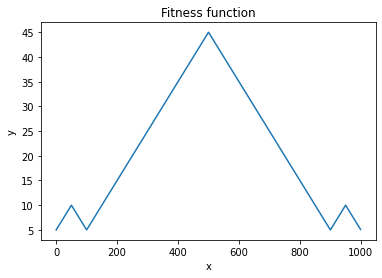

In [4]:
# Problem 2: Wide Basin Global Peak
def f2(x):
    """
    Fitness must be non-negative, as mlrose evaluates probability simply as fitness/sum(fitness in population)
    """
    if isinstance(x, np.ndarray):  # For compatibility with (one-element) state vector in mlrose
        assert x.shape == (1,)
        x = x[0]
    assert 0 <= x < 1000
    if 0 <= x < 100:
        return 10 - abs(x - 50) / 10
    elif x < 900:
        return 45 - abs(x - 500) / 10
    else:
        return 10 - abs(x - 950) / 10
    
plot_fitness_function(f2)

In [5]:
# Problem 3: 0-1 Knapsack Problem
# Reference: https://mlrose.readthedocs.io/en/stable/source/fitness.html#mlrose.fitness.Knapsack
# Best solution from Dynamic Programming: max total value = 7733
values = [
    360, 83, 59, 130, 431, 67, 230, 52, 93, 125, 670, 892, 600, 38, 48, 147,
    78, 256, 63, 17, 120, 164, 432, 35, 92, 110, 22, 42, 50, 323, 514, 28,
    87, 73, 78, 15, 26, 78, 210, 36, 85, 189, 274, 43, 33, 10, 19, 389, 276,
    312
]
weights = [
    7, 1, 30, 22, 80, 94, 11, 81, 70, 64, 59, 18, 1, 36, 3, 8, 15, 42, 9, 1,
    42, 47, 52, 32, 26, 48, 55, 6, 29, 84, 2, 4, 18, 56, 7, 29, 93, 44, 71,
    3, 86, 66, 31, 65, 1, 79, 20, 65, 52, 13
]
max_weight_pct = 0.5
f3 = mlrose.Knapsack(weights, values, max_weight_pct)

## Apply each algorithm on each problem

In [6]:
def plot_fitness_curve(fitness_curve):
    iters = list(range(1, len(fitness_curve) + 1))
    plt.plot(iters, fitness_curve)
    plt.title('Fitness curve')
    plt.xlabel('Iteration')
    plt.ylabel('Fitness')
    plt.show()

In [7]:
all_parameters = {
    # Parameters for Problem 1
    'p1': {
        'random_hill_climb': {
            'restarts': 5,
        },
        'simulated_annealing': {
            'schedule': mlrose.ExpDecay(init_temp=1.0, exp_const=0.05, min_temp=0.001),
        },
        'genetic_alg': {
            'pop_size': 200,
            'mutation_prob': 0.4,  # Should be reasonably high to reach the sharp peak fast
        },
        'mimic': {
            'pop_size': 200,
            'keep_pct': 0.2,
        },
    },
    # Parameters for Problem 2
    'p2': {
        'random_hill_climb': {
            'restarts': 5,
        },
        'simulated_annealing': {
            'schedule': mlrose.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001),
        },
        'genetic_alg': {
            'pop_size': 200,
            'mutation_prob': 0.1,
        },
        'mimic': {
            'pop_size': 200,
            'keep_pct': 0.2,
        },
    },
    # Parameters for Problem 3
    'p3': {
        'random_hill_climb': {
            'restarts': 5,
        },
        'simulated_annealing': {
            'schedule': mlrose.ExpDecay(init_temp=1.0, exp_const=0.005, min_temp=0.001),
        },
        'genetic_alg': {
            'pop_size': 200,
            'mutation_prob': 0.1,
        },
        'mimic': {
            'pop_size': 200,
            'keep_pct': 0.2,
        },
    },
}

In [8]:
global_optimums = {
    'p1': 15,
    'p2': 45,
    'p3': 7733,
}

In [9]:
def estimate_time_to_reach_global_optimum_or_stopping_condition(total_time, fitness_curve, global_optimum):
    """
    Return time consumed to reach global optimum, if it happended before the algorithm reached stopping condition
    Otherwise, return the time consumed to reach stopping condidition (i.e., algorithm stopped)
    In addition, return a boolean var indicating whether the global optimum was reached or not
    """
    for i, fitness in enumerate(fitness_curve):
        if abs(fitness - global_optimum) / global_optimum <= 0.001:
            return (i + 1) / len(fitness_curve) * total_time, True
    return total_time, False

In [10]:
def randomized_optimization(fitness_func, algorithm, parameters, random_state):
    if isinstance(fitness_func, mlrose.fitness.Knapsack):
        problem = mlrose.DiscreteOpt(
            length=len(fitness_func.weights),
            fitness_fn=fitness_func,
            maximize=True,
            max_val=2,  # Limit to 0-1 Knapsack Problem
        )
    else:
        fitness = mlrose.CustomFitness(fitness_func)
        problem = mlrose.DiscreteOpt(length=1, fitness_fn=fitness, maximize=True, max_val=1000)
    start_time = time.time()
    if algorithm == 'random_hill_climb':
        best_state, best_fitness, fitness_curve = mlrose.random_hill_climb(
            problem,
            max_attempts=100,
            max_iters=1000,
            init_state=np.zeros(problem.length),
            random_state=random_state,
            curve=True,
            **parameters,
        )
    elif algorithm == 'simulated_annealing':
        best_state, best_fitness, fitness_curve = mlrose.simulated_annealing(
            problem,
            max_attempts=100,
            max_iters=1000,
            init_state=np.zeros(problem.length),
            random_state=random_state,
            curve=True,
            **parameters,
        )
    elif algorithm == 'genetic_alg':
        best_state, best_fitness, fitness_curve = mlrose.genetic_alg(
            problem,
            max_attempts=100,
            max_iters=1000,
            random_state=random_state,
            curve=True,
            **parameters,
        )
    elif algorithm == 'mimic':
        best_state, best_fitness, fitness_curve = mlrose.mimic(
            problem,
            max_attempts=10,
            max_iters=1000,
            random_state=random_state,
            curve=True,
            **parameters,
        )
    else:
        raise ValueError('Algorithm {} is not supported!'.format(algoritm))
    end_time = time.time()
    total_time = end_time - start_time
    return best_state, best_fitness, fitness_curve, total_time

-------------------------------------------------------------
Result for algorithm random_hill_climb applied on problem 1
-------------------------------------------------------------
Best state after all tries with different random seeds = [500.]
Best fitness after all tries with different random seeds = 15.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.5141913992396772
Global optimum reached 7 out of 10 times


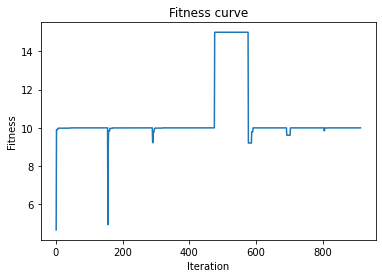

-------------------------------------------------------------
Result for algorithm simulated_annealing applied on problem 1
-------------------------------------------------------------


/usr/local/lib/python3.8/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


Best state after all tries with different random seeds = [500.]
Best fitness after all tries with different random seeds = 15.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.24499815797158914
Global optimum reached 2 out of 10 times


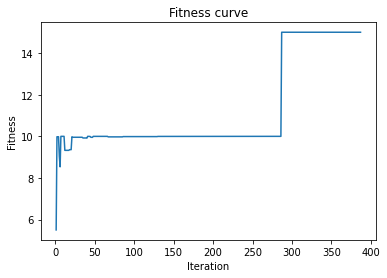

-------------------------------------------------------------
Result for algorithm genetic_alg applied on problem 1
-------------------------------------------------------------
Best state after all tries with different random seeds = [500]
Best fitness after all tries with different random seeds = 15.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.21764418961500792
Global optimum reached 10 out of 10 times


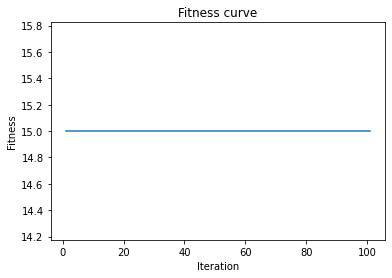

-------------------------------------------------------------
Result for algorithm mimic applied on problem 1
-------------------------------------------------------------
Best state after all tries with different random seeds = [500]
Best fitness after all tries with different random seeds = 15.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.033781322565945716
Global optimum reached 2 out of 10 times


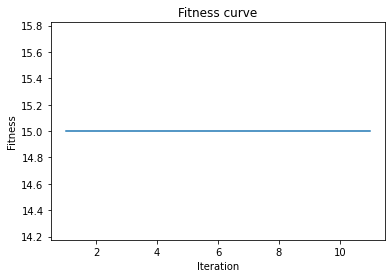

-------------------------------------------------------------
Result for algorithm random_hill_climb applied on problem 2
-------------------------------------------------------------
Best state after all tries with different random seeds = [500.]
Best fitness after all tries with different random seeds = 45.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.47524725648781424
Global optimum reached 7 out of 10 times


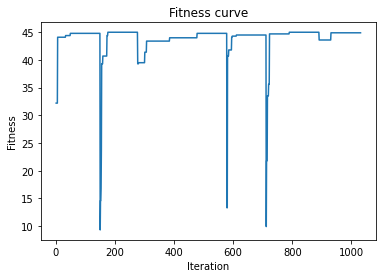

-------------------------------------------------------------
Result for algorithm simulated_annealing applied on problem 2
-------------------------------------------------------------
Best state after all tries with different random seeds = [500.]
Best fitness after all tries with different random seeds = 45.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.18868962153813645
Global optimum reached 4 out of 10 times


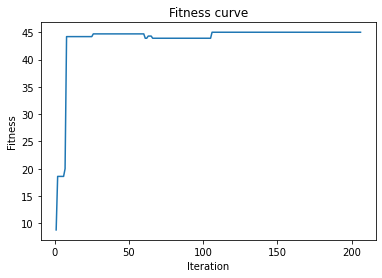

-------------------------------------------------------------
Result for algorithm genetic_alg applied on problem 2
-------------------------------------------------------------
Best state after all tries with different random seeds = [500]
Best fitness after all tries with different random seeds = 45.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.7748090383320116
Global optimum reached 10 out of 10 times


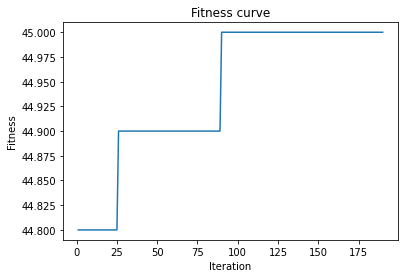

-------------------------------------------------------------
Result for algorithm mimic applied on problem 2
-------------------------------------------------------------
Best state after all tries with different random seeds = [500]
Best fitness after all tries with different random seeds = 45.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.026082142916592686
Global optimum reached 2 out of 10 times


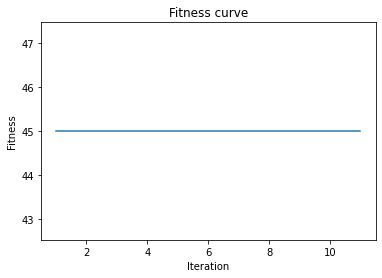

-------------------------------------------------------------
Result for algorithm random_hill_climb applied on problem 3
-------------------------------------------------------------
Best state after all tries with different random seeds = [1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 1.]
Best fitness after all tries with different random seeds = 6950.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.05002408027648926
Global optimum reached 0 out of 10 times


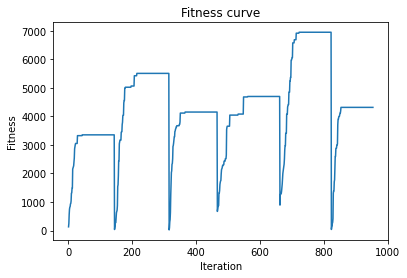

-------------------------------------------------------------
Result for algorithm simulated_annealing applied on problem 3
-------------------------------------------------------------
Best state after all tries with different random seeds = [1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0.
 0. 1.]
Best fitness after all tries with different random seeds = 5768.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 0.008923912048339843
Global optimum reached 0 out of 10 times


/usr/local/lib/python3.8/site-packages/mlrose/algorithms.py:311: RuntimeWarning: overflow encountered in exp
  prob = np.exp(delta_e/temp)


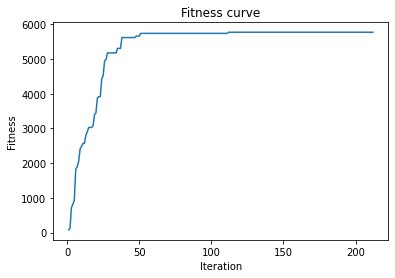

-------------------------------------------------------------
Result for algorithm genetic_alg applied on problem 3
-------------------------------------------------------------
Best state after all tries with different random seeds = [1 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 0 0 0 0 0
 1 1 1 1 0 1 0 1 0 1 1 1 1]
Best fitness after all tries with different random seeds = 7126.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 3.7107768774032595
Global optimum reached 0 out of 10 times


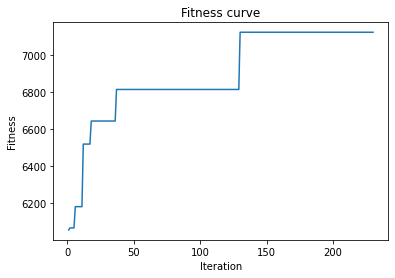

-------------------------------------------------------------
Result for algorithm mimic applied on problem 3
-------------------------------------------------------------
Best state after all tries with different random seeds = [1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 1 1 1 0 1 0 0
 0 1 1 0 1 1 0 1 0 0 1 1 1]
Best fitness after all tries with different random seeds = 7731.0
Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = 15.190163271200088
Global optimum reached 2 out of 10 times


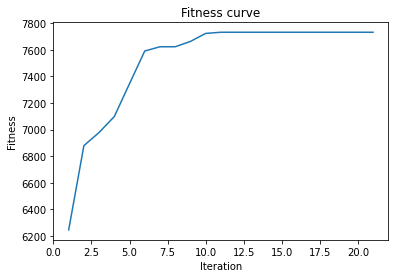

In [11]:
fitness_funcs = [f1, f2, f3]
algorithms = ['random_hill_climb', 'simulated_annealing', 'genetic_alg', 'mimic']
for i, fitness_func in enumerate(fitness_funcs):
    for algorithm in algorithms:
        print('-------------------------------------------------------------')
        print('Result for algorithm {0} applied on problem {1}'.format(algorithm, i + 1))
        print('-------------------------------------------------------------')
        best_fitness_all_tries = -sys.maxsize
        best_state_all_tries = None
        best_fitness_curve_all_tries = None
        effective_times = []
        bools_global_optimum_reached = []
        for random_state in range(10):
            best_state, best_fitness, fitness_curve, total_time = randomized_optimization(
                fitness_func,
                algorithm,
                all_parameters['p{}'.format(i + 1)][algorithm],
                random_state,
            )
            effective_time, global_optimum_reached \
                = estimate_time_to_reach_global_optimum_or_stopping_condition(
                    total_time, fitness_curve, global_optimums['p{}'.format(i + 1)],
                )
            effective_times.append(effective_time)
            bools_global_optimum_reached.append(global_optimum_reached)
            if best_fitness > best_fitness_all_tries:
                best_fitness_all_tries = best_fitness
                best_state_all_tries = best_state
                best_fitness_curve_all_tries = fitness_curve
        print('Best state after all tries with different random seeds = {}'.format(best_state_all_tries))
        print('Best fitness after all tries with different random seeds = {}'.format(best_fitness_all_tries))
        print('Time (averaged on all tries with different random seeds) to reach global optimum or stopping condition = {}'
              .format(sum(effective_times) / len(effective_times)))
        print('Global optimum reached {0} out of {1} times'
              .format(sum(bools_global_optimum_reached), len(bools_global_optimum_reached)))
        plot_fitness_curve(best_fitness_curve_all_tries)
                